<a href="https://colab.research.google.com/github/bifurcatum/eurostat_analytics/blob/main/inflation_wages_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For convinience all further manipulations with dataset will be commented inside the code with '#' while our general observations, concerning the researched data and detected patterns, will be displayed in separate text blocks.

In [1]:
# mount GoogleDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# define  project folder
import os

project_path = '/content/drive/MyDrive/Colab Notebooks/economic-analysis-estonia-eu'
os.chdir(project_path)
os.listdir('/content/drive/MyDrive/Colab Notebooks/economic-analysis-estonia-eu')

['readme.md',
 'estat_consumer_prices_monthly.tsv',
 'estat_wages.tsv',
 'inflation_long.csv',
 'inflation_wages_analysis.ipynb']

In [3]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

For the first step of our analyis we shall use data from Eurostat database (https://ec.europa.eu/eurostat/web/main/data/database) on Harmonised index of consumer prices (HIPC) calculated on a monthly basis with January 2015 concidered as a reference point of 100%.

In [4]:
# import data on price index from Eurostat
df_inflation = pd.read_csv('estat_consumer_prices_monthly.tsv', sep='\t', na_values=':')

df_inflation.head()

,"freq,unit,s_adj,indic,geo\TIME_PERIOD",1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03
0,"M,HICP2015,NSA,CP-HI00,AL",:,:,:,:,:,:,:,:,:,...,130.07 d,129.83 d,130.22 d,131.17 d,131.30 d,130.92 d,131.57 d,132.13 d,132.56 d,133.65 d
1,"M,HICP2015,NSA,CP-HI00,AT",71.34,71.55,71.77,71.69,71.62,71.84,71.91,71.69,71.69,...,134.44,133.95,133.77,134.13,134.63,135.00,135.92,137.13,137.82,138.27
2,"M,HICP2015,NSA,CP-HI00,BE",69.91,69.98,70.12,70.47,70.61,70.47,70.40,70.40,70.54,...,131.56,130.76,132.73,132.21,132.90,133.13,134.12,133.07,136.32,135.71
3,"M,HICP2015,NSA,CP-HI00,BG",:,:,:,:,:,:,:,:,:,...,137.15,138.75,138.83,137.25,138.14,138.53,138.99,141.47,142.09,142.53
4,"M,HICP2015,NSA,CP-HI00,CH",:,:,:,:,:,:,:,:,:,...,107.44,107.89,107.86,107.50,107.48,106.92,106.86,106.80,106.95,106.86


In [5]:
# transform table from wide format into long format so that we could create a plot later on
df_inflation_long = df_inflation.melt(
    id_vars=df_inflation.columns[0],
    var_name='time',
    value_name='value'
)
df_inflation_long.head()


,"freq,unit,s_adj,indic,geo\TIME_PERIOD",time,value
0,"M,HICP2015,NSA,CP-HI00,AL",1996-01,:
1,"M,HICP2015,NSA,CP-HI00,AT",1996-01,71.34
2,"M,HICP2015,NSA,CP-HI00,BE",1996-01,69.91
3,"M,HICP2015,NSA,CP-HI00,BG",1996-01,:
4,"M,HICP2015,NSA,CP-HI00,CH",1996-01,:


In [6]:
# split metainfo column into sensible data
df_inflation_long.rename(columns={df_inflation_long.columns[0]: 'meta'}, inplace=True)

df_inflation_long[['freq', 'indicator', 'seasonal_adj', 'coicop', 'geo']] = df_inflation_long['meta'].str.split(',', expand=True)

df_inflation_long = df_inflation_long[['freq', 'indicator', 'seasonal_adj', 'coicop', 'geo', 'time', 'value']]

df_inflation_long.head()

,freq,indicator,seasonal_adj,coicop,geo,time,value
0,M,HICP2015,NSA,CP-HI00,AL,1996-01,:
1,M,HICP2015,NSA,CP-HI00,AT,1996-01,71.34
2,M,HICP2015,NSA,CP-HI00,BE,1996-01,69.91
3,M,HICP2015,NSA,CP-HI00,BG,1996-01,:
4,M,HICP2015,NSA,CP-HI00,CH,1996-01,:


In [7]:
# export raw dataset in case we need it elsewhere
df_inflation_long.to_csv('inflation_long.csv', index=False)

In [8]:
# necessary data filtration:
# monthly data; only inflation indicators; non-seasonally adjusted; coicop - all items; Estonia and EU average
df_inf_filtered = df_inflation_long[
    (df_inflation_long['freq'] == 'M') &
    (df_inflation_long['indicator'] == 'HICP2015') &
    (df_inflation_long['seasonal_adj'] == 'NSA') &
    (df_inflation_long['coicop'] == 'CP-HI00') &
    (df_inflation_long['geo'].isin(['EE', 'EU27_2020']))
].copy()

# convert to numeric
df_inf_filtered['value'] = df_inf_filtered['value'].str.strip()
df_inf_filtered['value'] = df_inf_filtered['value'].replace(':', pd.NA)
df_inf_filtered['value'] = pd.to_numeric(df_inf_filtered['value'], errors='coerce')
df_inf_filtered = df_inf_filtered.dropna(subset=['value'])

# sort by time
df_inf_filtered.sort_values(['geo', 'time'], inplace=True)

df_inf_filtered.tail(15)

,freq,indicator,seasonal_adj,coicop,geo,time,value
1046319,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-01,127.21
1049433,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-02,127.95
1052547,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-03,128.79
1055661,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-04,129.55
1058775,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-05,129.79
1061889,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-06,130.02
1065003,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-07,130.19
1068117,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-08,130.33
1071231,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-09,130.23
1074345,M,HICP2015,NSA,CP-HI00,EU27_2020,2024-10,130.70


In [9]:
# check if we have unexpected zeros in data
(df_inf_filtered['value'] == 0).sum()

np.int64(0)

In [10]:
# checking data types in the DF
df_inf_filtered.dtypes

,0
freq,object
indicator,object
seasonal_adj,object
coicop,object
geo,object
time,object
value,float64


In [11]:
# query shows that our 'time' data is of 'object' type thus may not be interpreted correctly
# adding date column
df_inf_filtered['time'] = df_inf_filtered['time'].str.strip()
df_inf_filtered['date'] = pd.to_datetime(df_inf_filtered['time'], format='%Y-%m', errors='coerce')
df_inf_filtered = df_inf_filtered.dropna(subset=['date'])


In [12]:
df_inf_filtered.dtypes

,0
freq,object
indicator,object
seasonal_adj,object
coicop,object
geo,object
time,object
value,float64
date,datetime64[ns]


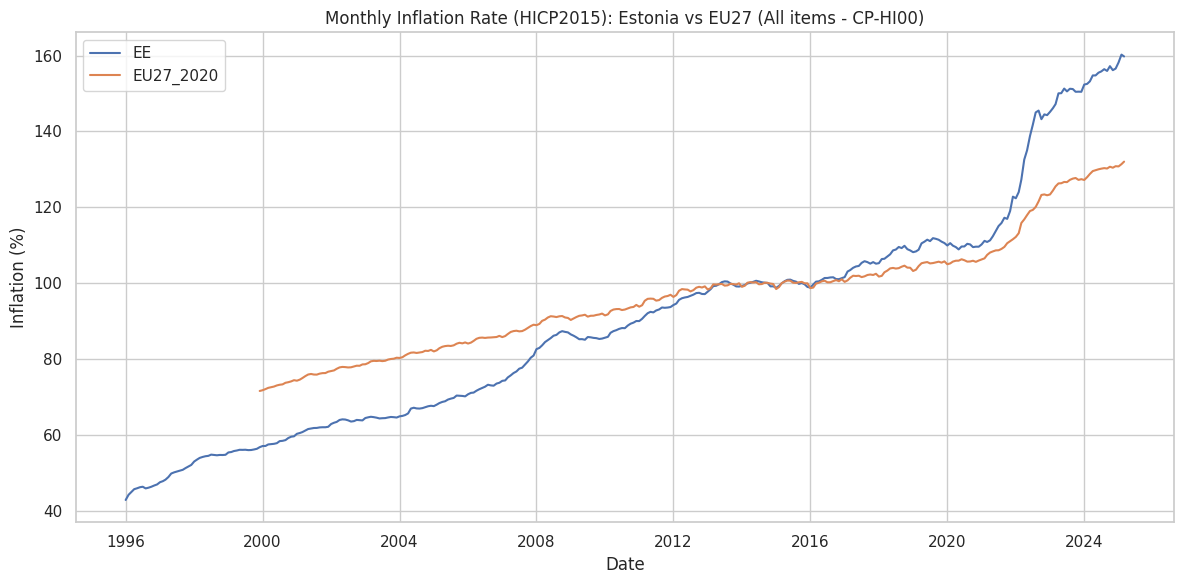

In [13]:
# making a plot on inflation data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# plot each region
for geo in df_inf_filtered['geo'].unique():
    subset = df_inf_filtered[df_inf_filtered['geo'] == geo]
    plt.plot(subset['date'], subset['value'], label=geo)

plt.title('Monthly Inflation Rate (HICP2015): Estonia vs EU27 (All items - CP-HI00)')
plt.xlabel('Date')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As plot shows that after 2021 Estonia inflation has grown notably faster than EU average, let's take a closer look at the recent period.



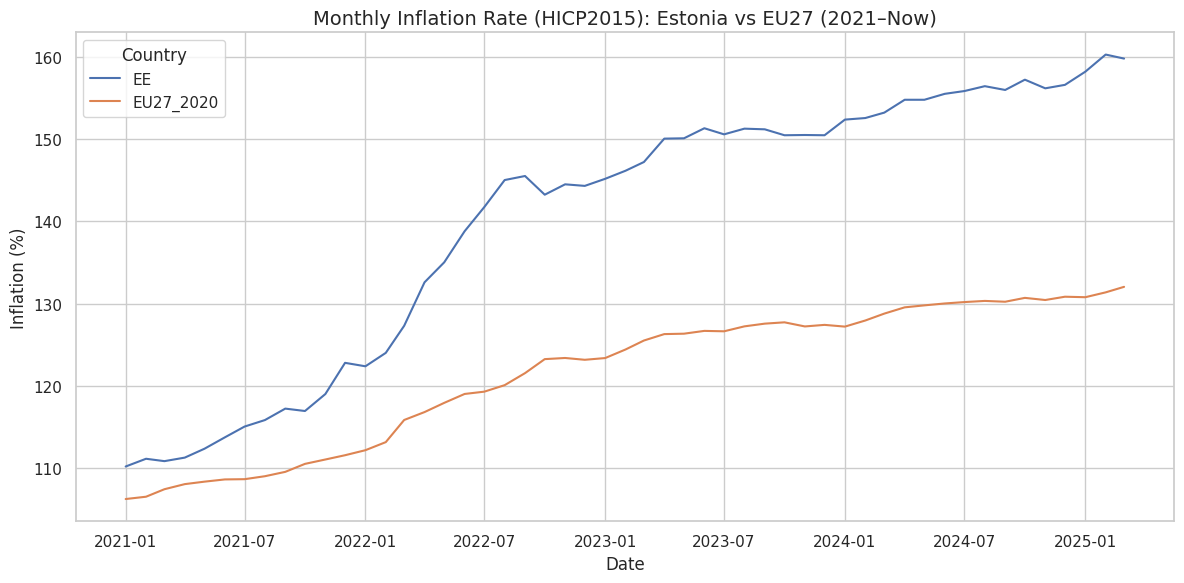

In [14]:
df_inf_recent = df_inf_filtered[df_inf_filtered['date'] >= '2021-01-01']

plt.figure(figsize=(12, 6))

for geo in df_inf_recent['geo'].unique():
    subset = df_inf_recent[df_inf_recent['geo'] == geo]
    plt.plot(subset['date'], subset['value'], label=geo)

plt.title('Monthly Inflation Rate (HICP2015): Estonia vs EU27 (2021–Now)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Inflation (%)')
plt.grid(True)
plt.legend(title='Country')
plt.tight_layout()
plt.show()

Still, due to the fact that HIPC is calclated versus Y2015 our plot is not perfectly informative. In the next step we shall try to replot data using month-to-month inflation rate (that we shall calculate ourselves).

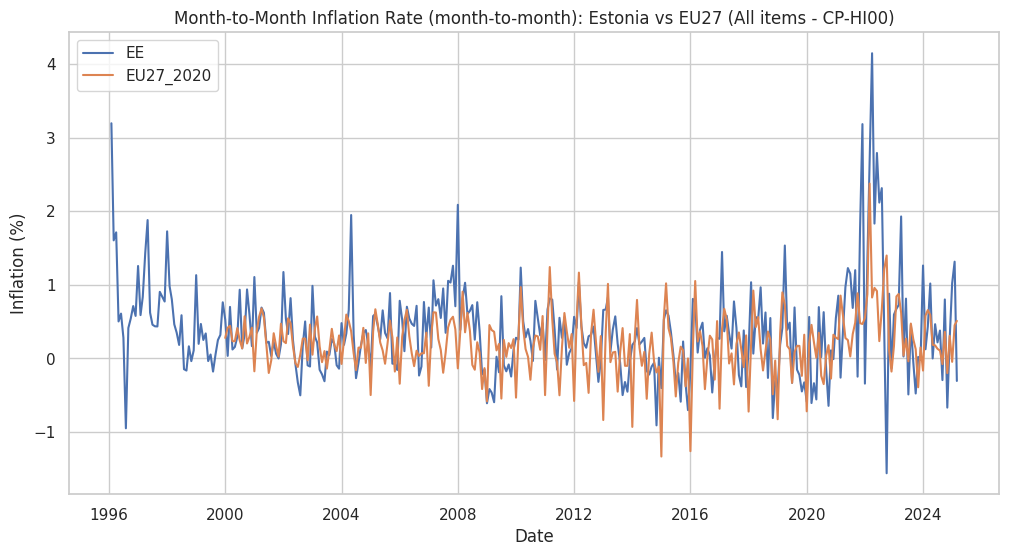

In [15]:
# calculating month-to-month inflation rate on data grouped by geo
df_inf_filtered = df_inf_filtered.sort_values(['geo', 'date'],)
df_inf_filtered['month_to_month_rate'] = df_inf_filtered.groupby('geo')['value'].pct_change() * 100

# making a plot on inflation data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# plot each region
for geo in df_inf_filtered['geo'].unique():
    subset = df_inf_filtered[df_inf_filtered['geo'] == geo]
    plt.plot(subset['date'], subset['month_to_month_rate'], label=geo)

plt.title('Month-to-Month Inflation Rate (month-to-month): Estonia vs EU27 (All items - CP-HI00)')
plt.xlabel('Date')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)



Month-to-month inflation graph shows that in-year seasonal inflation fluctuations are comparable in scale with the average inflation rate and the plot is not informative.
In the next step we can check our assumption that the plot is erratic due to seasonal fluctuations and try to find the cause of this fluctuations that seem to have regular pattern.

In [17]:
# add moving average with a 12 month lag
window_size = 12

df_inf_filtered['month_to_month_rate_ma'] = df_inf_filtered.groupby('geo')['month_to_month_rate'].transform(lambda x: x.rolling(window_size).mean())
df_inf_filtered.describe()

,value,date,month_to_month_rate,month_to_month_rate_ma
count,655.000000,655,653.000000,631.000000
mean,92.842336,2011-06-29 05:34:10.076335872,0.297131,0.289611
min,42.870000,1996-01-01 00:00:00,-1.560137,-0.178907
25%,76.940000,2004-10-01 00:00:00,-0.025556,0.128775
50%,94.280000,2011-08-01 00:00:00,0.261971,0.224672
75%,105.075000,2018-05-16 12:00:00,0.546644,0.357595
max,160.250000,2025-03-01 00:00:00,4.147357,1.895454
std,23.726253,NaN,0.553586,0.285975


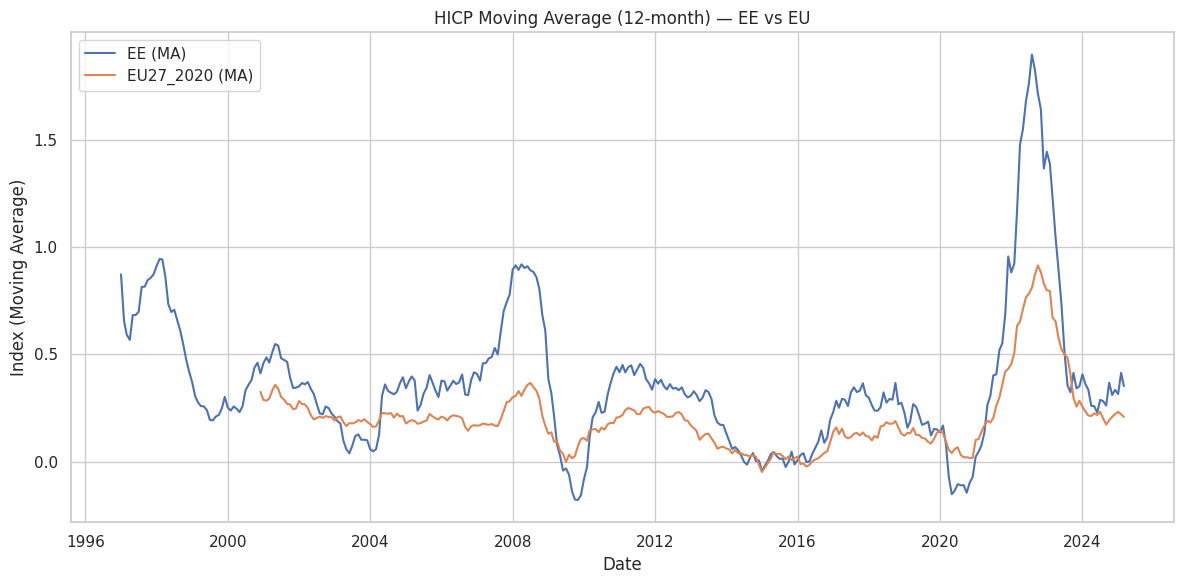

In [18]:
import matplotlib.pyplot as plt

selected_geos = ['EE', 'EU27_2020']

plt.figure(figsize=(12, 6))

for geo in selected_geos:
    df_plot = df_inf_filtered[df_inf_filtered['geo'] == geo]
    plt.plot(df_plot['date'], df_plot['month_to_month_rate_ma'], label=f'{geo} (MA)')

plt.title(f'HICP Moving Average ({window_size}-month) — EE vs EU')
plt.xlabel('Date')
plt.ylabel('Index (Moving Average)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As we smoothed out month-to-month inflation change by using 12-month moving average we can see that patterns in owerall EU and Estonia inflation are similar, whereas Estonian market shows a stronger reaction to the factors that cause inflation/deflation than EU in general. Let's try to locate which commodities have the sthrongest weight in inflation trends.

In [19]:
# all other data except CP-HI00 (all goods) was cleaned out in previous steps:
df_inf_filtered['coicop'].unique()

array(['CP-HI00'], dtype=object)

In [21]:
# move back to previously saved full dataset to pick out data we need
# necessary data filtration:
# monthly data; only inflation indicators; non-seasonally adjusted; coicop - except CP-HI00; Estonia and EU average
df_inf_drivers = df_inflation_long[
    (df_inflation_long['freq'] == 'M') &
    (df_inflation_long['indicator'] == 'HICP2015') &
    (df_inflation_long['seasonal_adj'] == 'NSA') &
    (df_inflation_long['coicop'] != 'CP-HI00') &
    (df_inflation_long['geo'].isin(['EE', 'EU27_2020']))
].copy()

# convert to numeric
df_inf_drivers['value'] = df_inf_drivers['value'].str.strip()
df_inf_drivers['value'] = df_inf_drivers['value'].replace(':', pd.NA)
df_inf_drivers['value'] = pd.to_numeric(df_inf_drivers['value'], errors='coerce')
df_inf_drivers = df_inf_drivers.dropna(subset=['value'])

# sort by date
df_inf_drivers['time'] = df_inf_drivers['time'].str.strip()
df_inf_drivers['date'] = pd.to_datetime(df_inf_drivers['time'], format='%Y-%m', errors='coerce')
df_inf_drivers = df_inf_drivers.dropna(subset=['date'])
df_inf_drivers.sort_values(['geo', 'date'], inplace=True)

df_inf_drivers.tail(15)

,freq,indicator,seasonal_adj,coicop,geo,time,value,date
1090330,M,HICP2015,NSA,CP-HI05,EU27_2020,2025-03,120.45,2025-03-01
1090372,M,HICP2015,NSA,CP-HI06,EU27_2020,2025-03,121.23,2025-03-01
1090414,M,HICP2015,NSA,CP-HI07,EU27_2020,2025-03,128.63,2025-03-01
1090456,M,HICP2015,NSA,CP-HI08,EU27_2020,2025-03,92.89,2025-03-01
1090498,M,HICP2015,NSA,CP-HI09,EU27_2020,2025-03,120.78,2025-03-01
1090540,M,HICP2015,NSA,CP-HI10,EU27_2020,2025-03,120.30,2025-03-01
1090582,M,HICP2015,NSA,CP-HI11,EU27_2020,2025-03,140.84,2025-03-01
1090624,M,HICP2015,NSA,CP-HI12,EU27_2020,2025-03,129.80,2025-03-01
1090666,M,HICP2015,NSA,CP-HIE,EU27_2020,2025-03,151.61,2025-03-01
1090707,M,HICP2015,NSA,CP-HIF,EU27_2020,2025-03,146.90,2025-03-01


In [24]:
# take period from 2020
df_since_2020 = df_inf_drivers[df_inf_drivers['date'] >= '2020-01-01']

# find delta for each commodity and location
df_coicop_delta = df_since_2020.groupby(['coicop', 'geo'])['value'].agg(['first', 'last'])
df_coicop_delta['delta'] = df_coicop_delta['last'] - df_coicop_delta['first']
df_coicop_delta = df_coicop_delta.reset_index()

# sort by delta
top_inflation_drivers = df_coicop_delta.sort_values('delta', ascending=False)
top_inflation_drivers.head()

,coicop,geo,first,last,delta
16,CP-HI04,EE,107.25,201.44,94.19
34,CP-HIE,EE,112.66,203.24,90.58
10,CP-HI01,EE,113.08,174.49,61.41
38,CP-HIFU,EE,118.21,176.67,58.46
36,CP-HIF,EE,115.98,172.97,56.99


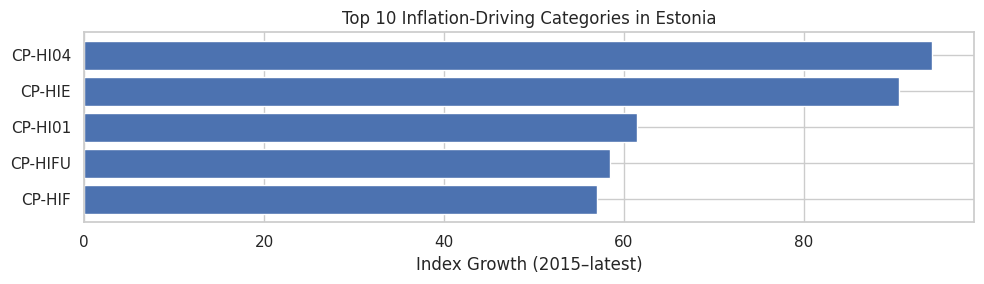

In [30]:
top_ee = top_inflation_drivers[top_inflation_drivers['geo'] == 'EE'].nlargest(5, 'delta')

plt.figure(figsize=(10, 3))
plt.barh(top_ee['coicop'], top_ee['delta'])
plt.xlabel('Index Growth (2015–latest)')
plt.title('Top 10 Inflation-Driving Categories in Estonia')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

* CP-HI04 - Housing, water, electricity, gas and other fuels
* CP-HIE - Restaurants and hotels
* CP-HI01 - Food and non-alcoholic beverages
* CP-HIFU - Transport services
* CP-HIF - Transport


As we can see from the plot, top inflation drivers in Estonia are housing and utilities costs, price of hospitality services, food prices and transport costs.